# Regressor Model

## 0. Dependencies

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

## Read datasest

#### stores

In [14]:
train = pd.read_csv('train_cleaned.csv', parse_dates=True, index_col=['Date'])

In [15]:
train.head(2)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,days,weekofyear,salespercustomers
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400


In [16]:
train.shape

(844338, 13)

In [17]:
train.isnull().sum()

Store                0
DayOfWeek            0
Sales                0
Customers            0
Open                 0
Promo                0
StateHoliday         0
SchoolHoliday        0
year                 0
month                0
days                 0
weekofyear           0
salespercustomers    0
dtype: int64

In [18]:
train.dtypes.value_counts()

int64      11
float64     1
object      1
dtype: int64

### Data Preparation

In [19]:
train.select_dtypes('object').columns

Index(['StateHoliday'], dtype='object')

In [20]:
train.StateHoliday.unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [21]:
# convert to numerical
mapping = {'0':0, 'a':1, 'b':2, 'c':3}

train.StateHoliday.replace(mapping, inplace = True)

## 2. Feature Selections

In [23]:
y = train['Sales']
X = train.drop('Sales', axis =1)
X.shape, y.shape

((844338, 12), (844338,))

### Split train-test 

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

## 3. Model

In [26]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

In [27]:
XGB = XGBRegressor()
XGB.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
yhat = XGB.predict(X_test)

### Evaluation

In [29]:
from sklearn import metrics

In [64]:
r2 = metrics.r2_score(y_test, yhat)

In [65]:
r2

0.9993151904235793

### Tuning Parameters

In [34]:
import scipy.stats as st
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

- eta: tamaño de paso utilizado para actualizar los pesos. Un valor más bajo significa un entrenamiento más lento pero una mejor convergencia.
- num_round: número total de iteraciones.
- subsample: la proporción de datos de entrenamiento utilizados en cada iteración; combate sobreajuste. Debe configurarse en el rango del 30% al 80% del conjunto de datos de entrenamiento y compararse con un valor del 100% si no hay muestreo.
- colsample_bytree: la proporción de características utilizadas en cada iteración, por defecto 1.
- max_depth: la profundidad máxima de cada árbol. Si no limitamos la profundidad máxima, el aumento de gradiente eventualmente se sobreajustará.
- early_stopping_rounds: si no hay un aumento en la puntuación de validación para un número determinado de iteraciones, el algoritmo se detendrá antes y también combatirá el sobreajuste.

In [58]:
# base parameters
params = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', # regression task
    'subsample': 0.8, # 80% of data to grow trees and prevent overfitting
    'colsample_bytree': 0.85, # 85% of features used
    'eta': 0.1, 
    'max_depth': 10, 
    'seed': 42} # for reproducible results

In [60]:
predictors = [x for x in train.columns if x not in ['Customers', 'Sales', 'SalePerCustomer']]

In [61]:
predictors

['Store',
 'DayOfWeek',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'year',
 'month',
 'days',
 'weekofyear',
 'salespercustomers']

In [69]:
# XGB with xgboost library
dtrain = xgb.DMatrix(X_train[predictors], y_train)
dtest = xgb.DMatrix(X_test[predictors], y_test)

watchlist = [(dtrain, 'train'), (dtest, 'test')]

xgb_model = xgb.train(params, dtrain,evals = watchlist,
                      early_stopping_rounds = 7,  verbose_eval = True)

[10:49:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:6958.52978	test-rmse:6955.67383
[1]	train-rmse:6370.58789	test-rmse:6368.29883
[2]	train-rmse:5840.44189	test-rmse:5839.22754
[3]	train-rmse:5374.96826	test-rmse:5375.11377
[4]	train-rmse:4969.89062	test-rmse:4971.46240
[5]	train-rmse:4605.24023	test-rmse:4607.81836
[6]	train-rmse:4292.97022	test-rmse:4296.77686
[7]	train-rmse:4016.35059	test-rmse:4021.88892
[8]	train-rmse:3779.65894	test-rmse:3786.82422
[9]	train-rmse:3570.28857	test-rmse:3578.75781


In [70]:
# XGB with sklearn wrapper
# the same parameters as for xgboost model
params_sk = {'max_depth': 10, 
            'n_estimators': 300, # the same as num_rounds in xgboost
            'objective': 'reg:linear', 
            'subsample': 0.8, 
            'colsample_bytree': 0.85, 
            'learning_rate': 0.1, 
            'seed': 42}     

In [74]:
#skrg = XGBRegressor(**params_sk)
#skrg.fit(X_train, y_train)

In [76]:
params_grid = {  
    'learning_rate': st.uniform(0.01, 0.3),
    'max_depth': list(range(10, 20, 2)),
    'gamma': st.uniform(0, 10),
    'reg_alpha': st.expon(0, 50)}

In [77]:
#RdCV = RandomizedSearchCV(skrg, params_grid, cv=5)
#RdCV.fit(X_train, y_train)#

In [54]:
# with new parameters
params_new = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', 
    'subsample': 0.8, 
    'colsample_bytree': 0.85, 
    'eta': 0.044338624448041611, 
    'max_depth': 16, 
    'gamma': 0.80198330585415034,
    'reg_alpha': 23.008226565535971,
    'seed': 42} 

**Nota**  
No jecutare tuneo de los parametros ya que consume muchos recursos en cuanto al tiempo

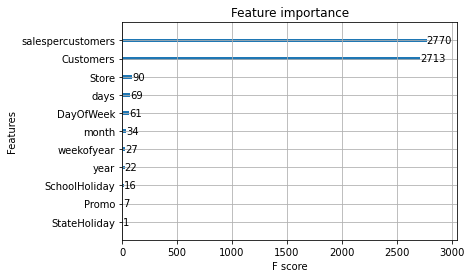

In [57]:
xgb.plot_importance(XGB);